## RAG

### 1. pgvector 가져오기

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS") 
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

In [25]:
# 방법 1. psycopg2 연결 그대로 langchain pgvector 연결

from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import PGVector

PGVECTOR_CONNECTION_STRING = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
EMBEDDING_MODEL = "text-embedding-3-small"

try:
    embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)
except Exception as e:
    print(f"오류 ::: OpenAI 클라이언트 초기화 실패 : {e}")

vector_store = PGVector.from_existing_index(
    embedding = embeddings,
    collection_name = "BOOK_CHUNKS",
    connection_string = PGVECTOR_CONNECTION_STRING
)
print("PGVector 연결 성공 ::: ",  vector_store)

PGVector 연결 성공 :::  <langchain_community.vectorstores.pgvector.PGVector object at 0x0000024F26EA0DD0>


c:\Reading_Mate\.venv\Lib\site-packages\langchain_community\vectorstores\pgvector.py:1096: LangChainPendingDeprecationWarning: Please use JSONB instead of JSON for metadata. This change will allow for more efficient querying that involves filtering based on metadata. Please note that filtering operators have been changed when using JSONB metadata to be prefixed with a $ sign to avoid name collisions with columns. If you're using an existing database, you will need to create a db migration for your metadata column to be JSONB and update your queries to use the new operators. 
  store = cls(


In [26]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 30}
)

user_input = "사이클론이 뭐야?"
results = retriever.invoke(user_input)

print(f"\n검색 결과: {len(results)}개")
for i, doc in enumerate(results[:5]):
    print(f"\n{'='*60}")
    print(f"결과 {i+1}")
    print(f"{'='*60}")
    print(f"챕터: {doc.metadata['chapter_name']}")
    print(f"내용: {doc.page_content[:200]}...")


검색 결과: 30개

결과 1
챕터: the_wizard_of_oz - 19번째 청크
내용: 허수아비는 장난스럽게 말했다. “우린 이제 머리, 가슴, 집, 그리고 용기를 찾는 여행자들이 되었군요.” 도로시가 웃었다. “그리고 토토는 우리 모두의 친구!” 그들은 함께 노란 벽돌길을 따라 걸었다. 숲속은 점점 밝아졌고, 새들이 다시 노래하기 시작했다. 도로시는 마음속으로 생각했다. ‘이제 정말 좋은 친구들을 만났어.’ 길을 걷던 중 사자가 물었다. “...

결과 2
챕터: the_wizard_of_oz - 18번째 청크
내용: 바구니를 들고 토토를 안았으며, 사방이 고요한 숲속을 조심스레 지나갔다. 그러던 중, 갑자기 커다란 포효 소리가 울려 퍼졌다. “으르르르——!!!” 순식간에 커다란 사자가 덤벼들어 토토를 향해 뛰어들었다! 도로시는 비명을 지르며 앞으로 달려들었다. “토토를 건드리지 마!” 그녀는 두려움도 잊은 채 사자의 코를 손바닥으로 내리쳤다. 사자는 깜짝 놀라 뒷걸음질...

결과 3
챕터: the_wizard_of_oz - 0번째 청크
내용: 오즈의 마법사 지은이: L. 프랭크 바움 제1장. 사이클론 (The Cyclone) 도로시는 캔자스의 넓은 대초원 한가운데에서 살고 있었다. 그녀는 농부인 헨리 아저씨와 그의 아내 엠 아주머니와 함께 살았다. 그들의 집은 아주 작았는데, 그것은 나무를 운반해오는 데 오랜 시간이 걸렸기 때문이다. 집은 벽 네 개와 바닥, 지붕으로 이루어진 단 하나의 방뿐이었...

결과 4
챕터: the_wizard_of_oz - 71번째 청크
내용: 곳이 어딘지 알게 되는 것 같아.” 토토가 그녀의 무릎에 머리를 기대었다. 도로시는 미소 지었다. “이젠 어디에도 가지 않을 거야. 집이 제일이니까.” 바람이 살짝 불며 커튼이 흔들렸다. 도로시는 하늘을 보며 마음속으로 친구들을 떠올렸다 — 허수아비, 양철 나무꾼, 그리고 사자. 그들이 각자의 자리에서 잘 지내고 있을 거라 믿었다....

결과 5
챕터: the_wizard_of

### chain 만들기

#### 1) pgvector 연결 함수

In [ ]:
def get_vector_store(collection_name="BOOK_CHUNKS"):
    """기존 PGVector 연결"""

    DB_NAME = os.getenv("DB_NAME")
    DB_USER = os.getenv("DB_USER")
    DB_PASS = os.getenv("DB_PASS") 
    DB_HOST = os.getenv("DB_HOST")
    DB_PORT = os.getenv("DB_PORT")
    
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    PGVECTOR_CONNECTION_STRING = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    
    vector_store = PGVector.from_existing_index(
        embedding=embeddings,
        collection_name=collection_name,
        connection_string=PGVECTOR_CONNECTION_STRING
    )
    
    return vector_store

#### 2) retrieve 함수

In [ ]:
def search_books(query, k=5):
    """책 내용 검색"""
    vector_store = get_vector_store()
    retriever = vector_store.as_retriever(
        search_type="similarity",
        search_kwargs={"k": k}
    )
    return retriever

#### 3) 문서 합치는 함수

In [ ]:
def format_docs(docs):
    tmp_docs = []
    for item in docs:
        tmp_docs.append(item.page_content)
    return "\n\n---\n\n".join(tmp_docs)

    # return "\n\n".join([f"[{doc.metadata.get('chapter_name', 'N/A')}]\n{doc.page_content}" for doc in docs])

In [ ]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import PGVector
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

# 1. 설정
user_input = "사이클론이 뭐야?"
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)
retriever = search_books(user_input)

# 2. 프롬프트
template = """다음 컨텍스트를 바탕으로 질문에 답변하세요:

{context}

질문: {question}
답변:"""

prompt = ChatPromptTemplate.from_template(template)

# 3. 기본 체인 구성


# 4. RAG 체인 구성
rag_chain = (
    {
        "context": retriever | RunnableLambda(format_docs),
        "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# 5. 사용
question = "사이클론이 뭐야?"
answer = rag_chain.invoke(question)

print(f"질문: {question}")
print(f"\n답변:\n{answer}")

### (함수 생성)

In [30]:
def get_vector_store(collection_name="BOOK_CHUNKS"):
    """기존 PGVector 연결"""

    DB_NAME = os.getenv("DB_NAME")
    DB_USER = os.getenv("DB_USER")
    DB_PASS = os.getenv("DB_PASS") 
    DB_HOST = os.getenv("DB_HOST")
    DB_PORT = os.getenv("DB_PORT")
    
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    PGVECTOR_CONNECTION_STRING = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    
    vector_store = PGVector.from_existing_index(
        embedding=embeddings,
        collection_name=collection_name,
        connection_string=PGVECTOR_CONNECTION_STRING
    )
    
    return vector_store

In [31]:
def search_books(query, k=5):
    """책 내용 검색"""
    vector_store = get_vector_store()
    retriever = vector_store.as_retriever(
        search_type="similarity",
        search_kwargs={"k": k}
    )
    results = retriever.invoke(query)
    return results

In [33]:
# 사용
results = search_books("사이클론이 뭐야?", k=30)

for i, doc in enumerate(results[:5]):
    print(f"\n{'='*60}")
    print(f"결과 {i+1}")
    print(f"{'='*60}")
    print(f"챕터: {doc.metadata['chapter_name']}")
    print(f"내용: {doc.page_content[:200]}...")
    print(f"book_id: {doc.metadata['book_id']}")

c:\Reading_Mate\.venv\Lib\site-packages\langchain_community\vectorstores\pgvector.py:1096: LangChainPendingDeprecationWarning: Please use JSONB instead of JSON for metadata. This change will allow for more efficient querying that involves filtering based on metadata. Please note that filtering operators have been changed when using JSONB metadata to be prefixed with a $ sign to avoid name collisions with columns. If you're using an existing database, you will need to create a db migration for your metadata column to be JSONB and update your queries to use the new operators. 
  store = cls(



결과 1
챕터: the_wizard_of_oz - 19번째 청크
내용: 허수아비는 장난스럽게 말했다. “우린 이제 머리, 가슴, 집, 그리고 용기를 찾는 여행자들이 되었군요.” 도로시가 웃었다. “그리고 토토는 우리 모두의 친구!” 그들은 함께 노란 벽돌길을 따라 걸었다. 숲속은 점점 밝아졌고, 새들이 다시 노래하기 시작했다. 도로시는 마음속으로 생각했다. ‘이제 정말 좋은 친구들을 만났어.’ 길을 걷던 중 사자가 물었다. “...
book_id: 1

결과 2
챕터: the_wizard_of_oz - 18번째 청크
내용: 바구니를 들고 토토를 안았으며, 사방이 고요한 숲속을 조심스레 지나갔다. 그러던 중, 갑자기 커다란 포효 소리가 울려 퍼졌다. “으르르르——!!!” 순식간에 커다란 사자가 덤벼들어 토토를 향해 뛰어들었다! 도로시는 비명을 지르며 앞으로 달려들었다. “토토를 건드리지 마!” 그녀는 두려움도 잊은 채 사자의 코를 손바닥으로 내리쳤다. 사자는 깜짝 놀라 뒷걸음질...
book_id: 1

결과 3
챕터: the_wizard_of_oz - 0번째 청크
내용: 오즈의 마법사 지은이: L. 프랭크 바움 제1장. 사이클론 (The Cyclone) 도로시는 캔자스의 넓은 대초원 한가운데에서 살고 있었다. 그녀는 농부인 헨리 아저씨와 그의 아내 엠 아주머니와 함께 살았다. 그들의 집은 아주 작았는데, 그것은 나무를 운반해오는 데 오랜 시간이 걸렸기 때문이다. 집은 벽 네 개와 바닥, 지붕으로 이루어진 단 하나의 방뿐이었...
book_id: 1

결과 4
챕터: the_wizard_of_oz - 71번째 청크
내용: 곳이 어딘지 알게 되는 것 같아.” 토토가 그녀의 무릎에 머리를 기대었다. 도로시는 미소 지었다. “이젠 어디에도 가지 않을 거야. 집이 제일이니까.” 바람이 살짝 불며 커튼이 흔들렸다. 도로시는 하늘을 보며 마음속으로 친구들을 떠올렸다 — 허수아비, 양철 나무꾼, 그리고 사자. 그들이 각자의 자리에서 잘 지내고 있을 거라 믿었다....
bo

In [34]:
book_id = results[0].metadata['book_id']
print(book_id)

1


In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import PGVector
import os

def get_vector_store(collection_name="BOOK_CHUNKS"):
    """기존 PGVector 연결"""

    DB_NAME = os.getenv("DB_NAME")
    DB_USER = os.getenv("DB_USER")
    DB_PASS = os.getenv("DB_PASS") 
    DB_HOST = os.getenv("DB_HOST")
    DB_PORT = os.getenv("DB_PORT")
    
    PGVECTOR_CONNECTION_STRING = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    
    vector_store = PGVector.from_existing_index(
        embedding=embeddings,
        collection_name=collection_name,
        connection_string=PGVECTOR_CONNECTION_STRING
    )
    
    return vector_store

def search_books(query, k=5):
    """책 내용 검색"""
    vector_store = get_vector_store()
    retriever = vector_store.as_retriever(
        search_type="similarity",
        search_kwargs={"k": k}
    )
    results = retriever.invoke(query)
    return results

# 사용
results = search_books("사이클론이 뭐야?", k=30)

for i, doc in enumerate(results[:5]):
    print(f"\n{'='*60}")
    print(f"결과 {i+1}")
    print(f"{'='*60}")
    print(f"챕터: {doc.metadata['chapter_name']}")
    print(f"내용: {doc.page_content[:200]}...")

### 2. Node 생성

In [17]:
from typing import List, TypedDict

class KnowledgeSearchState(TypedDict):
    query : str         # 사용자가 입력한 질문
    route : str         # 질문경로 : rag / web
    rag_docs : List[dict]   # rag에서 가져온 문서 리스트(내용/메타데이터)
    web_docs : List[dict]   # 웹검색에서 가져온 문서 리스트(내용/메타데이터)
    grade : float       # doc_grader에서 평가한 문서 신뢰도 점수 (0~1)
    answer : str        # 최종 생성된 답변
    replan : bool       # 재계획 필요 여부
    log : List[str]     # 로그

In [ ]:
def _log(st: KnowledgeSearchState, msg: str) -> None:
    # 실행 로그를 추가하는 함수
    st.setdefault("log", []).append(msg)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

plan_system = (
    "당신은 전자책 도우미 챗봇이야. 독자의 질문에 간결하고 정확하게 대답한다."
    ""
)

def planner_node(state: KnowledgeSearchState) -> KnowledgeSearchState:
    user_input = state.get("query", "")

    prompt = ChatPromptTemplate.from_messages([
        ("system", plan_system),
        ("user", f"")
    ])

In [4]:
def rag_node(state: KnowledgeSearchState) -> KnowledgeSearchState:
    """
    RAG용 노드
    """
    user_input = state.get("query", "")
    retriever = vector_store.as_retriever(
        search_type = "similarity",
        search_kwargs = {"k" : 30}
    )
    result = retriever.invoke(user_input)
    
    return null

NameError: name 'KnowledgeSearchState' is not defined

In [20]:
def planner_node(state):
    return state

def route_query(state):
    if "책" in state["query"]:
        state["route"] = "rag"
    else:
        state["route"] = "web"
    return state

def rag_retrieve(state):
    state["rag_docs"] = ["책 내용 일부 ..."]
    return state

def web_search(state):
    state["web_docs"] = ["웹 검색 결과 ..."]
    return state

def doc_grader(state):
    return state

def generate_answer(state):
    state["answer"] = "이건 오즈의 마법사 배경 설명이에요..."
    return state

def hallucination_check(state):
    state["replan_needed"] = not bool(state["answer"])  # 간단 검증
    return state

def replan(state):
    state["route"] = "web"  # 재시도 시 웹으로
    state["rag_docs"] = []
    state["web_docs"] = []
    state["answer"] = ""
    return state


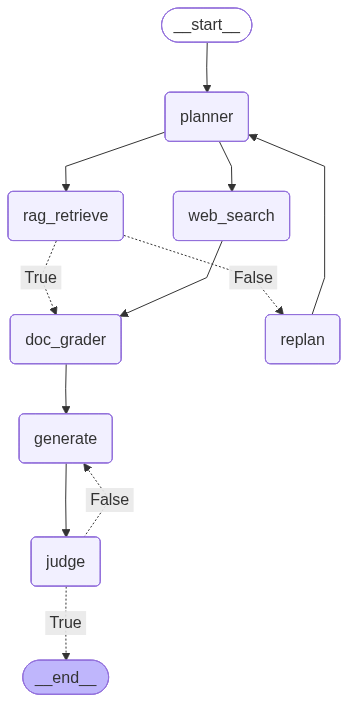

In [26]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(KnowledgeSearchState)

# 노드 추가
builder.add_node("planner", planner_node)
# builder.add_node("router", route_query)
builder.add_node("rag_retrieve", rag_retrieve)
builder.add_node("web_search", web_search)
builder.add_node("doc_grader", doc_grader)
builder.add_node("generate", generate_answer)
builder.add_node("judge", hallucination_check)
builder.add_node("replan", replan)

# START → router
builder.add_edge(START, "planner")

builder.add_edge("planner", "rag_retrieve")
builder.add_edge("planner", "web_search")

# router 분기
# builder.add_conditional_edges(
#     "router",
#     lambda state: state["route"],
#     {"rag": "rag_retrieve", "web": "web_search"}
# )

# 검색 → 평가 → 답변 생성
# builder.add_edge("rag_retrieve", "doc_grader")
builder.add_conditional_edges(
    "rag_retrieve",
    lambda state: state.get("rag_replan", False),  # rag_replan이 True면 재계획
    {False: "replan", True: "doc_grader"}
)
builder.add_edge("web_search", "doc_grader")
builder.add_edge("doc_grader", "generate")

# generate → judge
builder.add_edge("generate", "judge")

# judge에서 재계획 여부 분기
builder.add_conditional_edges(
    "judge",
    lambda state: state.get("replan", False),
    {False: "generate", True: END}  # 재계획 시 generate로 바로
)

# replan 후 router로 돌아가기
builder.add_edge("replan", "planner")

# 그래프 컴파일
graph = builder.compile()
graph


---

pgvector 테스트

In [21]:
def diagnose_pgvector():
    import psycopg2
    
    conn = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS
    )
    cursor = conn.cursor()
    
    print("=" * 50)
    print("PGVector 진단 시작")
    print("=" * 50)
    
    # 1. pgvector extension 확인
    cursor.execute("SELECT * FROM pg_extension WHERE extname = 'vector'")
    print("\n1. pgvector extension:", "설치됨" if cursor.fetchone() else "설치 안됨")
    
    # 2. 테이블 확인
    cursor.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public' 
        AND table_name LIKE '%langchain%'
    """)
    tables = cursor.fetchall()
    print("\n2. LangChain 관련 테이블:", tables)
    
    # 3. 컬렉션 확인
    try:
        cursor.execute("SELECT name, uuid FROM langchain_pg_collection")
        collections = cursor.fetchall()
        print("\n3. 컬렉션 목록:")
        for name, uuid in collections:
            print(f"   - {name} (UUID: {uuid})")
            
            # 각 컬렉션의 데이터 개수
            cursor.execute(f"""
                SELECT COUNT(*) 
                FROM langchain_pg_embedding 
                WHERE collection_id = '{uuid}'
            """)
            count = cursor.fetchone()[0]
            print(f"     데이터 개수: {count}")
    except Exception as e:
        print(f"\n3. 컬렉션 확인 실패: {e}")
    
    # 4. 전체 임베딩 데이터 확인
    try:
        cursor.execute("SELECT COUNT(*) FROM langchain_pg_embedding")
        total = cursor.fetchone()[0]
        print(f"\n4. 전체 임베딩 데이터 개수: {total}")
        
        if total > 0:
            cursor.execute("SELECT document FROM langchain_pg_embedding LIMIT 1")
            sample = cursor.fetchone()[0]
            print(f"\n   샘플 문서 (처음 100자):\n   {sample[:100]}...")
    except Exception as e:
        print(f"\n4. 데이터 확인 실패: {e}")
    
    cursor.close()
    conn.close()
    print("\n" + "=" * 50)

# 실행
diagnose_pgvector()

PGVector 진단 시작

1. pgvector extension: 설치됨

2. LangChain 관련 테이블: [('langchain_pg_collection',), ('langchain_pg_embedding',)]

3. 컬렉션 목록:
   - BOOK_CHUNKS (UUID: cd100e30-e909-4ab7-9aff-5b17c5164e91)
     데이터 개수: 0

4. 전체 임베딩 데이터 개수: 0



In [22]:
import psycopg2

conn = psycopg2.connect(
    host=DB_HOST, port=DB_PORT, database=DB_NAME,
    user=DB_USER, password=DB_PASS
)
cursor = conn.cursor()

# 테이블 구조 확인
cursor.execute("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'book_chunks'
    ORDER BY ordinal_position
""")
print("BOOK_CHUNKS 테이블 구조:")
for col in cursor.fetchall():
    print(f"  - {col[0]}: {col[1]}")

# 데이터 개수 확인
cursor.execute("SELECT COUNT(*) FROM BOOK_CHUNKS")
print(f"\n총 데이터 개수: {cursor.fetchone()[0]}")

cursor.close()
conn.close()

BOOK_CHUNKS 테이블 구조:
  - chunk_pk: bigint
  - book_id: integer
  - chunk_index: integer
  - chapter_name: text
  - text_content: text
  - embedding: USER-DEFINED

총 데이터 개수: 73
